In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from isaac.constants import FORCE_CLASS_COLS, MASS_CLASS_COLS, BASIC_TRAINING_COLS, PUCK_SQUARE_DISTANCES, PUCK_ANGLE_FEATURES
from isaac.training import evaluate_saved_model

In [2]:
from isaac.utils import get_cuda_device_if_available
device = get_cuda_device_if_available()
print(device)

cuda:0


In [3]:
sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams.update({'axes.labelsize': '22',
                     'xtick.labelsize':'18',
                     'ytick.labelsize': '18',
                     'legend.fontsize': '18',
                     'figure.figsize': (8, 8),
                     'font.size': 22})

def increase_linewidth(ax):
    lines = ax.get_lines()
    for line in lines:
        line.set_linewidth(3)
    leg = ax.legend()
    leg_lines = leg.get_lines()
    plt.setp(leg_lines, linewidth=5)

In [4]:
question_type = "mass"
directory = "multibranch_plots/"
stats = pd.read_hdf(directory+"stats.h5")

In [5]:
stats.head()

,Epoch,Mass Loss,Force Loss,Mass Train Accuracy,Mass Val Accuracy,Force Train Accuracy,Force Val Accuracy,seed
0,0,1.117661,1.092678,50.0,30.0,50.0,30.0,0
1,1,0.973047,1.033161,60.0,30.0,80.0,30.0,0
0,0,1.077762,1.086447,70.0,10.0,60.0,30.0,42
1,1,0.982175,1.008167,70.0,10.0,60.0,50.0,42
0,0,1.063363,1.060718,50.0,30.0,60.0,30.0,72


/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


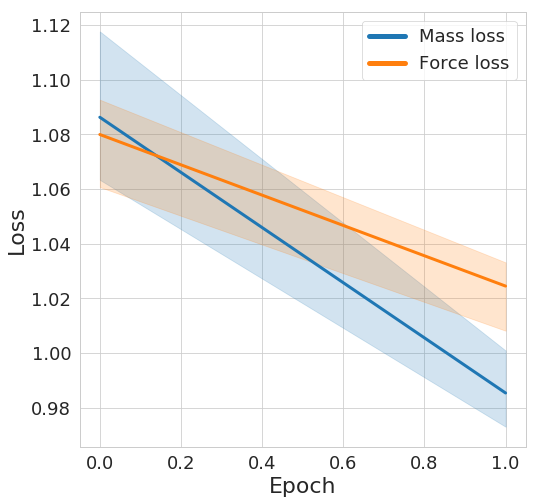

In [6]:
ax = sns.lineplot(x="Epoch", y="Mass Loss", markers=True, data=stats, linewidth=3, label="Mass loss")
ax = sns.lineplot(x="Epoch", y="Force Loss", markers=True, data=stats, linewidth=3, label="Force loss")
plt.ylabel("Loss")
increase_linewidth(ax)
plt.savefig(directory+"losses.pdf")

/home/hector/miniconda3/envs/diss/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


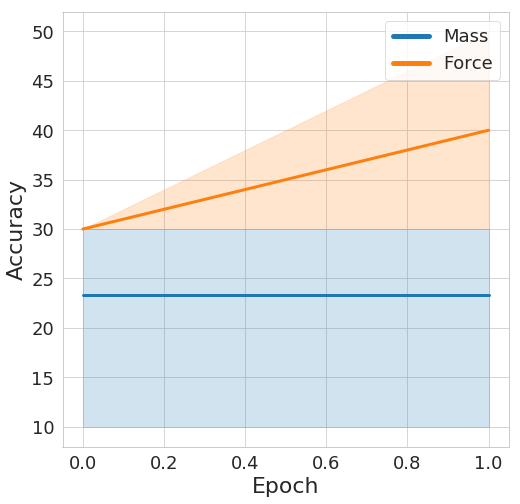

In [7]:
ax = sns.lineplot(x="Epoch", y="Mass Val Accuracy", data=stats, label="Mass")
ax = sns.lineplot(x="Epoch", y="Force Val Accuracy", data=stats, label="Force")
plt.legend()
plt.ylabel("Accuracy")
increase_linewidth(ax)
plt.savefig(directory+"accuracies.pdf")

In [8]:
sns.set_style("white")

In [9]:
def plot(predicted, i, class_columns, test_loader):
    predicted = [pred.cpu() for pred in predicted]
    Y_test = np.concatenate([y[:, i].cpu().numpy() for x, y in test_loader])

    # plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=False)
    plot_confusion_matrix(Y_test, predicted, classes=class_columns, normalize=True, )

In [10]:
import torch.nn as nn
import torch
from torch.autograd import Variable
import numpy as np
from isaac.utils import plot_confusion_matrix

class MultiBranchModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MultiBranchModel, self).__init__()
        # RNN
        self.base_gru = nn.GRU(input_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        # Readout layer
        self.gru1 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        self.gru2 = nn.GRU(hidden_dim, hidden_dim, 2, batch_first=True, dropout=dropout)
        
        self.fc1 = nn.Linear(hidden_dim, output_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.base_gru(x)
        
        out_1, _ = self.gru1(out)
        out_1 = self.fc1(out_1[:, -1, :]) 
        
        out_2, _ = self.gru2(out)
        out_2 = self.fc2(out_2[:, -1, :]) 
        return out_1, out_2
    
def get_current_prediction_and_number_of_correct_examples(y_hat, y_val):
    current_prediction = torch.max(y_hat.data, 1)[1]
    correct = (current_prediction == y_val).sum().cpu().numpy()
    return current_prediction, correct

def evaluate(model, val_loader, return_predicted=False, seq_start=None, seq_end=None, step_size=None):
    predicted = [[], []]
    accuracies = [[], []]

    mass_correct = 0
    force_correct = 0
    total = 0
    
    for x_val, y_val in val_loader:
        total += y_val.size(0)
        mass_val = y_val[:, 0]
        force_val = y_val[:, 1]

        x_val = Variable(x_val[:, seq_start:seq_end:step_size, :])
        mass_hat, force_hat = model(x_val)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(mass_hat, mass_val)
        mass_correct += correct
        predicted[0].extend(current_prediction)
        
        current_prediction, correct = get_current_prediction_and_number_of_correct_examples(force_hat, force_val)
        force_correct += correct
        predicted[1].extend(current_prediction)
        
    accuracies[0] = 100 * mass_correct / float(total)
    accuracies[1] = 100 * force_correct / float(total)
    
    if return_predicted:
        return accuracies[0], accuracies[1], predicted[0], predicted[1]
    
    return accuracies[0], accuracies[1]

  0%|          | 0/260 [00:00<?, ?it/s]

29.3


100%|██████████| 260/260 [00:00<00:00, 752.84it/s]


27.692307692307693


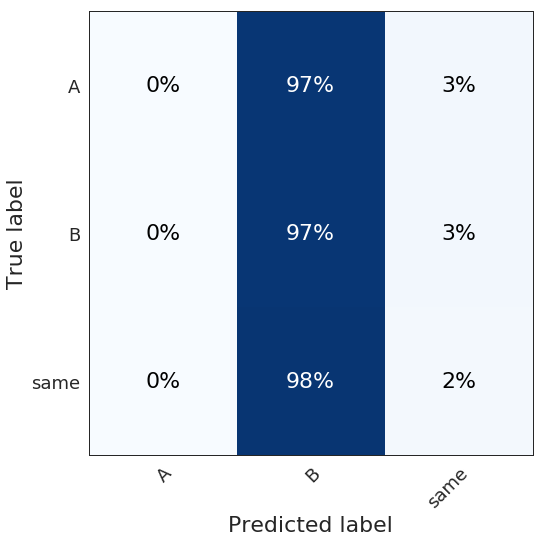

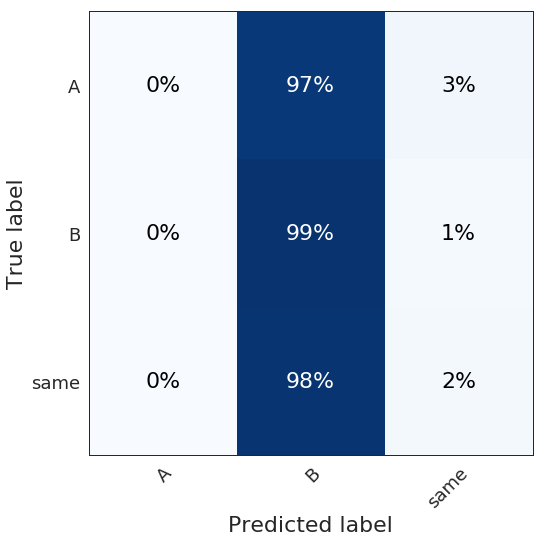

In [11]:
import joblib
from isaac.dataset import read_dataset, prepare_dataset

scaler = joblib.load("scalers/passive_dual_scaler.sk")

model = MultiBranchModel(len(BASIC_TRAINING_COLS), 25, 3)
model.load_state_dict(torch.load("models/passive_mass_dual_model.pt"))
model.eval()
model = model.to(device=device)

question_type = "mass"
paths = ["multibranch_plots/test_data_"+question_type+"_cm.pdf",
         "multibranch_plots/neils_data_"+question_type+"_cm.pdf"]

for test_dataset_path, path in zip(["data/test_passive_trials.h5", "data/passive_trials_exp1.h5"],
                                               paths):
    all_trials = read_dataset(test_dataset_path)
    test_loader, _ = prepare_dataset([all_trials], class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                     training_columns=BASIC_TRAINING_COLS, multiclass=True, scaler=scaler,
                                     normalise_data=True, device=device)
    mass_accuracy, _, mass_predicted, _ = evaluate(model, test_loader, return_predicted=True, seq_end=1800, step_size=3)
    print(mass_accuracy)
    plot(mass_predicted, 0, MASS_CLASS_COLS, test_loader)
    plt.savefig(path)

  0%|          | 0/260 [00:00<?, ?it/s]

31.2


100%|██████████| 260/260 [00:00<00:00, 747.29it/s]


30.76923076923077


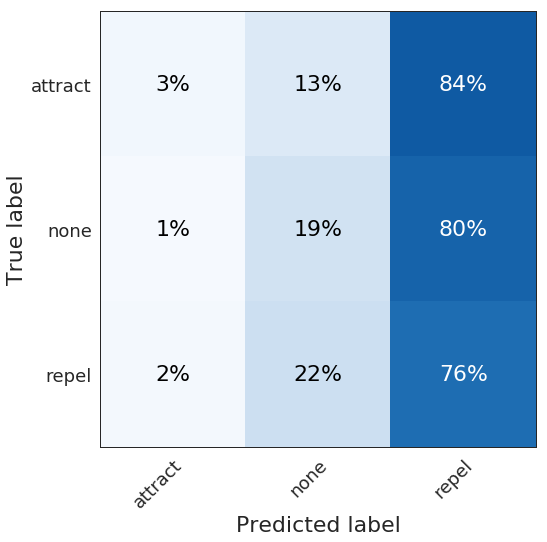

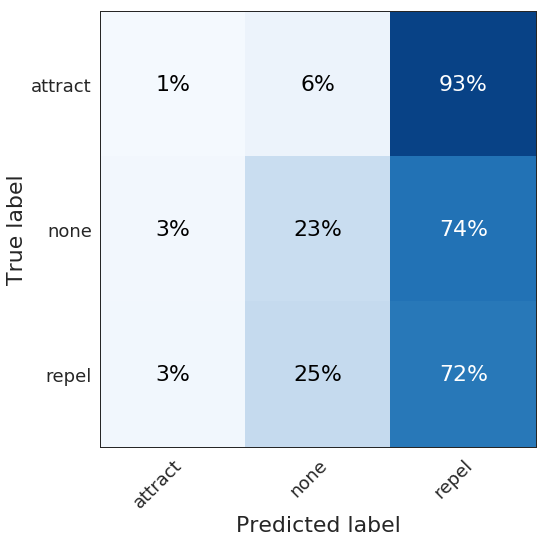

In [12]:
model = MultiBranchModel(len(BASIC_TRAINING_COLS), 25, 3)
model.load_state_dict(torch.load("models/passive_force_dual_model.pt"))
model.eval()
model = model.to(device=device)

question_type = "force"
paths = ["multibranch_plots/test_data_"+question_type+"_cm.pdf",
         "multibranch_plots/neils_data_"+question_type+"_cm.pdf"]

for test_dataset_path, path in zip(["data/test_passive_trials.h5", "data/passive_trials_exp1.h5"],
                                               paths):
    all_trials = read_dataset(test_dataset_path)
    test_loader, _ = prepare_dataset([all_trials], class_columns=[list(MASS_CLASS_COLS), list(FORCE_CLASS_COLS)], 
                                     training_columns=BASIC_TRAINING_COLS, multiclass=True, scaler=scaler,
                                     normalise_data=True, device=device)
    _, force_accuracy, _, force_predicted = evaluate(model, test_loader, return_predicted=True, seq_end=1800, step_size=3)
    print(force_accuracy)
    plot(force_predicted, 1, FORCE_CLASS_COLS, test_loader)
    plt.savefig(path)